In [13]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import seaborn as sns
from jax.scipy.special import bessel_jn
from numpyro import deterministic, plate, sample
from numpyro.handlers import seed, substitute, trace
from numpyro.infer import MCMC, NUTS
from PIL import Image

sns.set_theme('notebook', 'ticks', font='Arial')

plt.rcParams['figure.dpi'] = 200

# Trialing generative processes for chemical microscopy

Is it possible to use a generative process to model microscope images like this (and is it worth the effort?)

In [2]:
img = Image.open('data/example.jpg')
img = img.resize((img.width // 2, img.height // 2))

Try a couple of different colour spaces in case something interesting stands out.

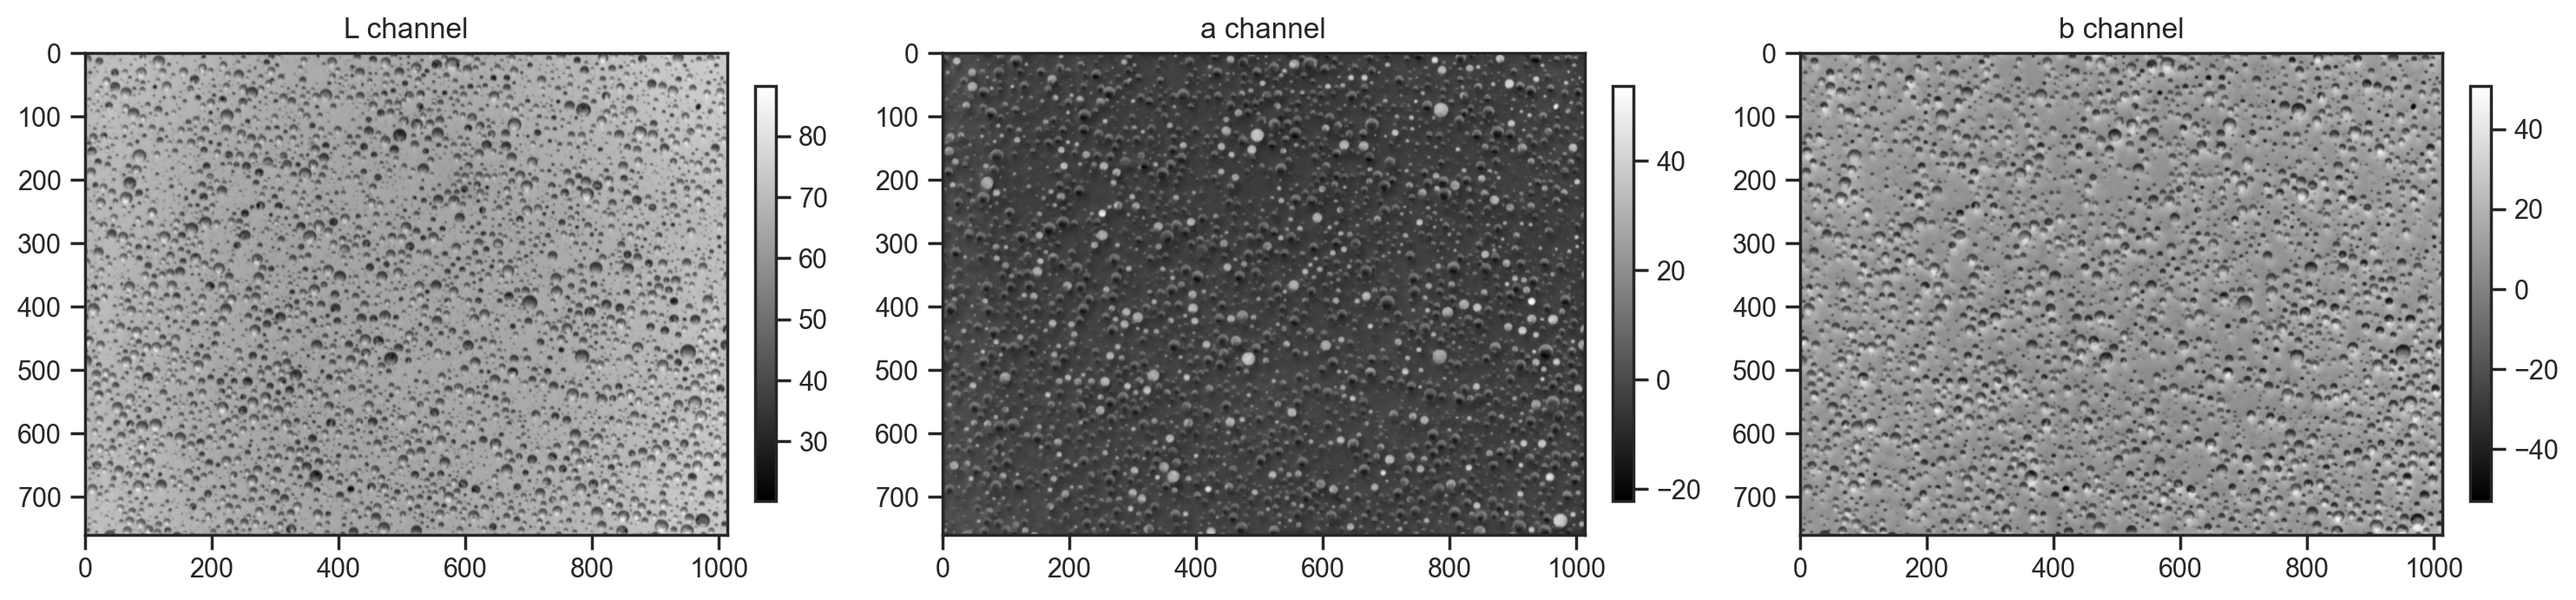

In [3]:
from skimage import color

img_array = np.array(img)
lab_img = color.rgb2lab(img_array)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (ax, title) in enumerate(zip(axes, ['L channel', 'a channel', 'b channel'])):
    im = ax.imshow(lab_img[:,:,i], cmap='gray')
    ax.set_title(title)
    fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)

plt.tight_layout()

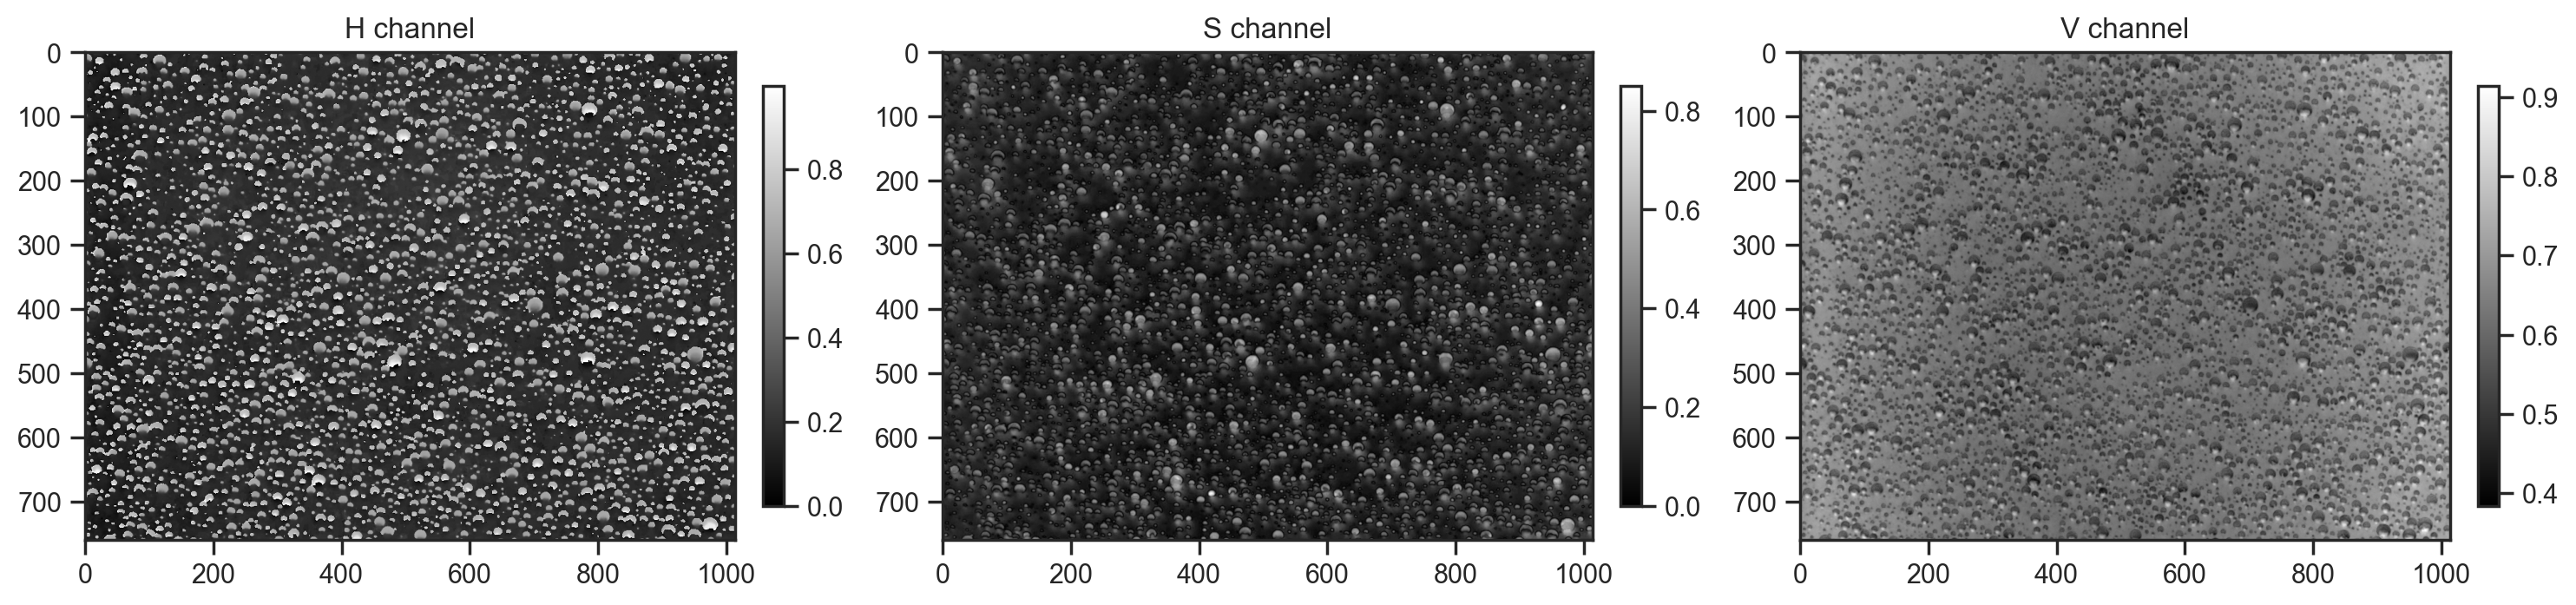

In [4]:
hsv_img = color.rgb2hsv(img_array)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (ax, title) in enumerate(zip(axes, ['H channel', 'S channel', 'V channel'])):
    im = ax.imshow(hsv_img[:,:,i], cmap='gray')
    ax.set_title(title)
    fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)

plt.tight_layout()

First approach, fixed number of droplets; model centres and radii

sample: 100%|██████████| 1100/1100 [00:00<00:00, 1106.20it/s, 15 steps of size 3.18e-01. acc. prob=0.84]


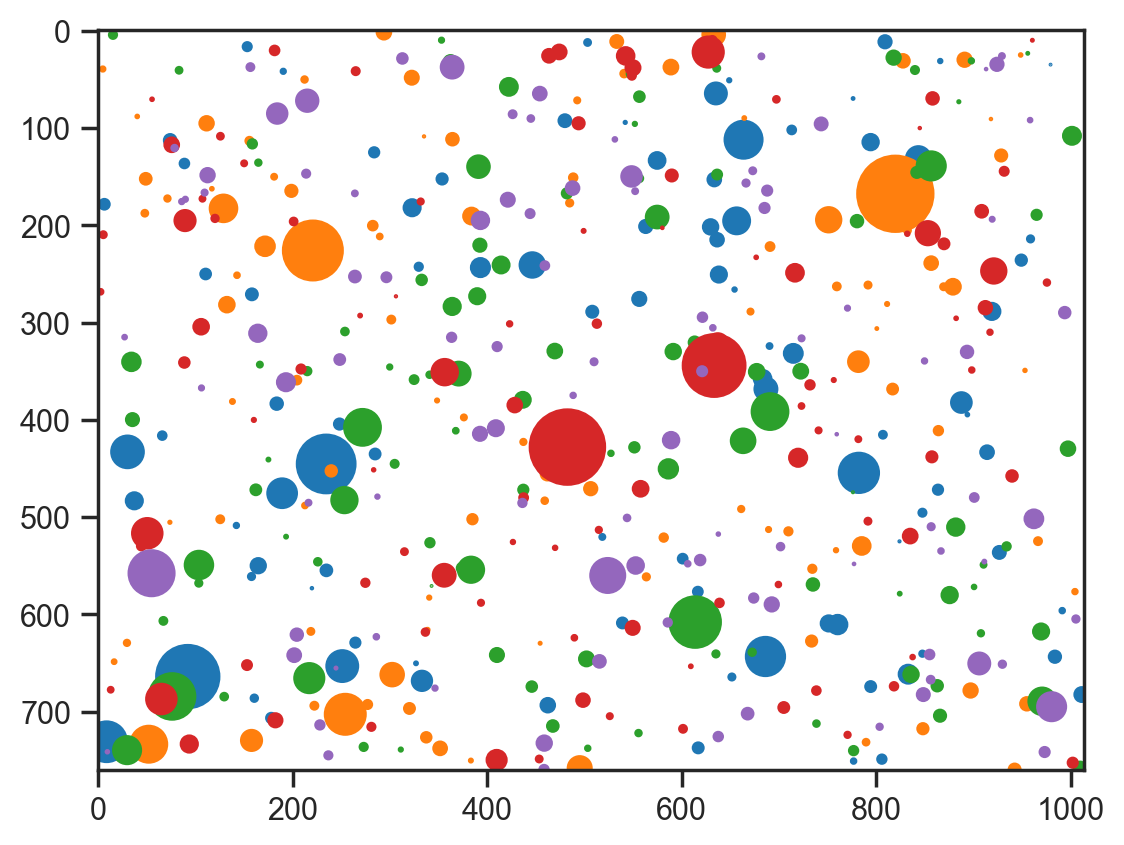

In [5]:
def model1(w, h, n_droplets):
    with plate("droplets", n_droplets):
        x = sample("x", dist.Uniform(0, w))
        y = sample("y", dist.Uniform(0, h))
        r = sample("r", dist.LogNormal(1.5, 0.75))


mcmc = MCMC(NUTS(model1), num_warmup=1000, num_samples=100)
mcmc.run(jax.random.PRNGKey(0), w=img.width, h=img.height, n_droplets=100)
samples = mcmc.get_samples()

fig, ax = plt.subplots()
ax.imshow(np.ones_like(np.array(img)) * 255, cmap="gray")
for sample_no in range(5):
    for i in range(100):
        circle = plt.Circle(
            (samples["x"][sample_no][i], samples["y"][sample_no][i]),
            samples["r"][sample_no][i],
            color=plt.cm.tab10(sample_no),
        )

        ax.add_artist(circle)

sample: 100%|██████████| 1100/1100 [00:01<00:00, 668.27it/s, 15 steps of size 2.67e-01. acc. prob=0.84]


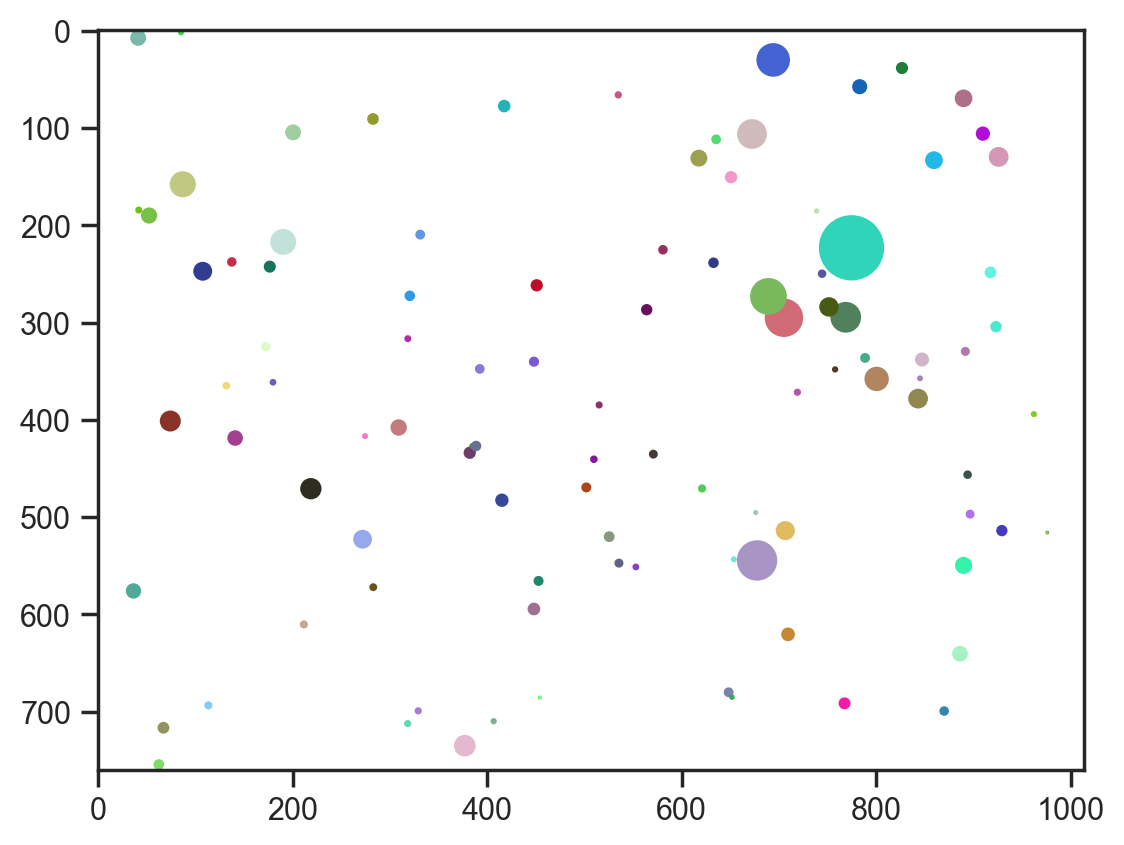

In [6]:
def model2(w, h, n_droplets):
    # Sample droplet locations and sizes
    with plate("droplets", n_droplets):
        x = sample("x", dist.Uniform(0, w))
        y = sample("y", dist.Uniform(0, h))
        r = sample("r", dist.LogNormal(1.5, 0.75))
        
        # Sample HSV values for each droplet
        h_val = sample("h", dist.Uniform(0, 1))
        s_val = sample("s", dist.Beta(2, 2))
        v_val = sample("v", dist.Beta(5, 2))  # Biased towards brighter values

mcmc = MCMC(NUTS(model2), num_warmup=1000, num_samples=100)
mcmc.run(jax.random.PRNGKey(0), w=img.width, h=img.height, n_droplets=100)
samples = mcmc.get_samples()
samples = {k: np.array(v) for k, v in samples.items()}

# Visualize with HSV colors
fig, ax = plt.subplots()
ax.imshow(np.ones_like(np.array(img)) * 255, cmap="gray")
for i in range(100):
    circle = plt.Circle(
        (samples["x"][0][i], samples["y"][0][i]),
        samples["r"][0][i],
        color=color.hsv2rgb(
            np.array(
                [
                    samples["h"][0][i],
                    samples["s"][0][i],
                    samples["v"][0][i],
                ]
            )
        ),
    )
    ax.add_artist(circle)

sample: 100%|██████████| 510/510 [00:28<00:00, 17.91it/s, 15 steps of size 3.16e-01. acc. prob=0.85]


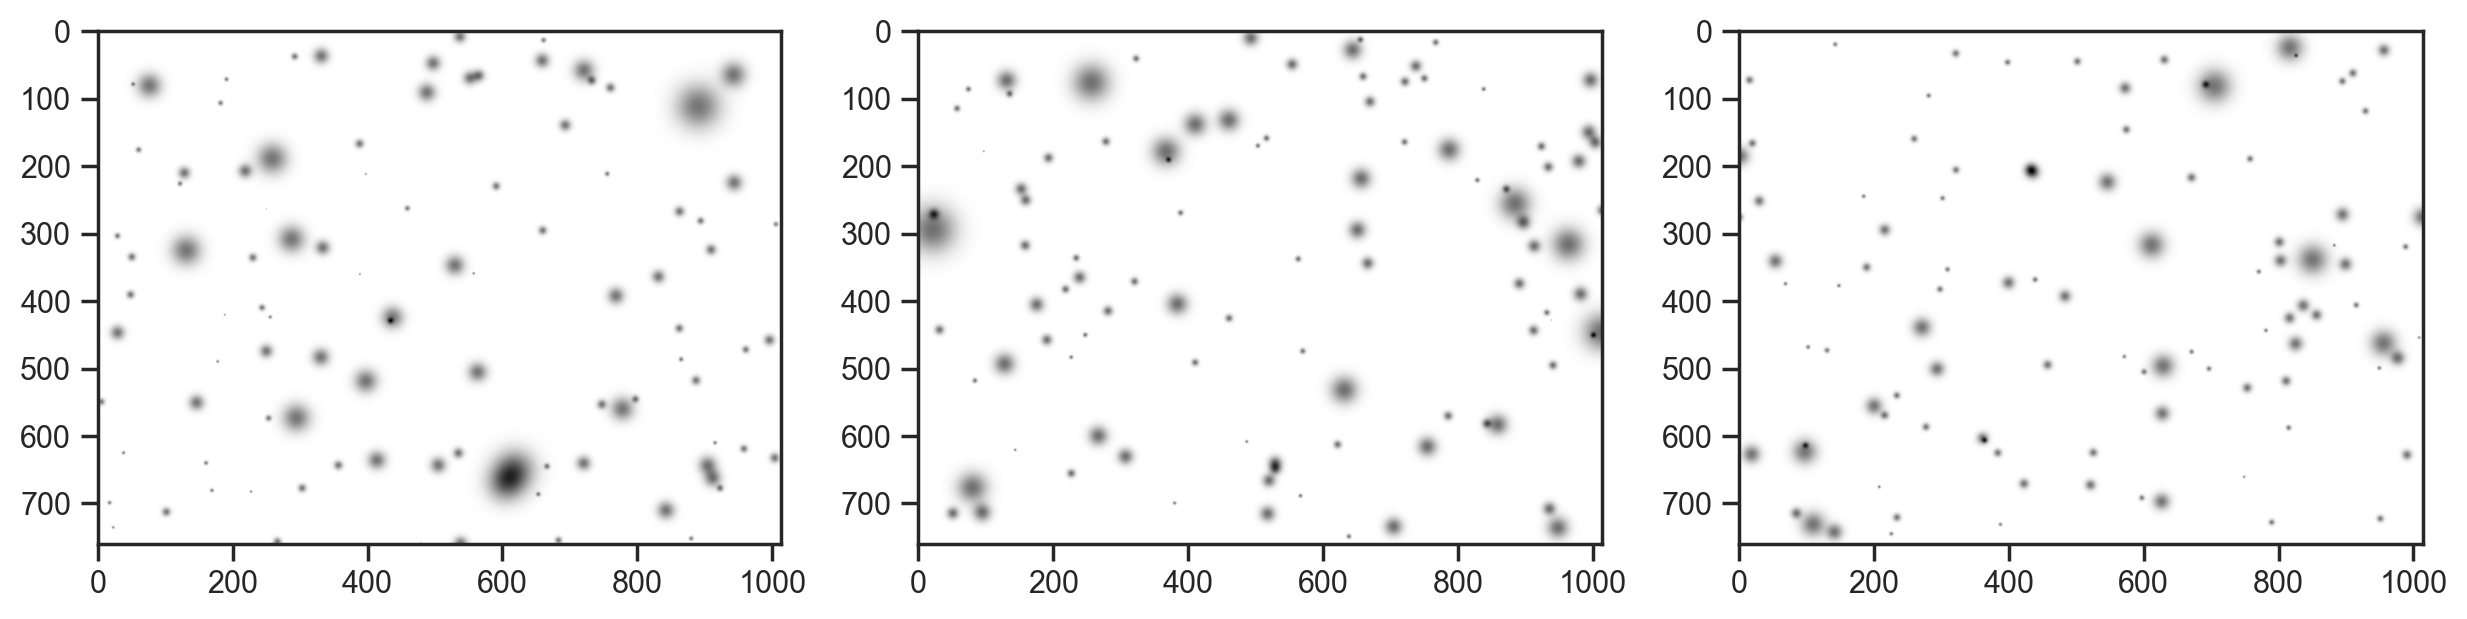

In [7]:
def model2(w, h, n_droplets):
    # Sample droplet locations and sizes
    with plate("droplets", n_droplets):
        x = sample("x", dist.Uniform(0, w))
        y = sample("y", dist.Uniform(0, h))
        r = sample("r", dist.LogNormal(1.5, 0.75))
        
        with plate("pixels", w * h):
            x_dist = jnp.abs(x - jnp.arange(w)[:, None])
            y_dist = jnp.abs(y - jnp.arange(h)[:, None])
            distance = jnp.sqrt(x_dist ** 2 + y_dist[:, None] ** 2)
            val = deterministic('val', jnp.sum(jnp.exp(-distance ** 2 / (2 * r ** 2)), axis=-1))


mcmc = MCMC(NUTS(model2), num_warmup=500, num_samples=10)
mcmc.run(jax.random.PRNGKey(0), w=img.width, h=img.height, n_droplets=100)
samples = mcmc.get_samples()
samples = {k: np.array(v) for k, v in samples.items()}

# show the first 3 samples
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(1 - samples['val'][i], cmap='gray')

Not a bad generative process to start with. Now let's just fit the hue channel ...

In [26]:
def model3(w, h, n_droplets, channel):
    # Sample droplet locations and sizes
    bg = sample("bg", dist.Uniform(0, 1))
    with plate("droplets", n_droplets):
        x = sample("x", dist.Uniform(0, w))
        y = sample("y", dist.Uniform(0, h))
        r = sample("r", dist.LogNormal(1.5, 0.75))
        amplitude = sample("amplitude", dist.Normal())
        
        x_dist = jnp.abs(x - jnp.arange(w)[:, None])
        y_dist = jnp.abs(y - jnp.arange(h)[:, None])
        distance = jnp.sqrt(x_dist ** 2 + y_dist[:, None] ** 2)
        val = deterministic('val', bg + jnp.sum(amplitude[None, None, :] * jnp.exp(-distance ** 2 / (2 * r ** 2)), axis=-1))
        diff = deterministic('diff', val - channel)
    sample('obs', dist.Normal(0, 1.0), obs=val - channel)

with seed(rng_seed=0):
    model_trace = trace(model3).get_trace(w=img.width, h=img.height, n_droplets=100, channel=hsv_img[:,:,0])
model_trace

OrderedDict([('bg',
              {'type': 'sample',
               'name': 'bg',
               'fn': <numpyro.distributions.continuous.Uniform at 0x325da3850>,
               'args': (),
               'kwargs': {'rng_key': Array([2718843009, 1272950319], dtype=uint32),
                'sample_shape': ()},
               'value': Array(0.10536897, dtype=float32),
               'scale': None,
               'is_observed': False,
               'intermediates': [],
               'cond_indep_stack': [],
               'infer': {}}),
             ('droplets',
              {'type': 'plate',
               'fn': <function numpyro.primitives._subsample_fn(size, subsample_size, rng_key=None)>,
               'name': 'droplets',
               'args': (100, None),
               'kwargs': {'rng_key': None},
               'value': Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
                      17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 

In [31]:
mcmc = MCMC(NUTS(model3, max_tree_depth=3), num_warmup=100, num_samples=100)
mcmc.run(jax.random.PRNGKey(0), w=img.width, h=img.height, n_droplets=100, channel=hsv_img[:,:,0])
samples = mcmc.get_samples()
samples = {k: np.array(v) for k, v in samples.items()}

# show the first 3 samples
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    im = ax.imshow(1 - samples['val'][i], cmap='gray')
    fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)

plt.tight_layout()

sample:  56%|█████▌    | 112/200 [03:03<02:24,  1.64s/it, 7 steps of size 2.57e-03. acc. prob=0.75]


KeyboardInterrupt: 